In [18]:
import ee
import geemap
from matplotlib import pyplot as plt 
import rasterio
from rasterio.plot import show
from osgeo import gdal
import numpy as np
from pyproj import Transformer



# Utilização básica do rasterio para ler tif

In [19]:
#Abrindo imagem com rasterio e vendo seus metadados
img = rasterio.open('D:\\codigos\\imagens\\imagem_teste_NDVI.tif')
img.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 995,
 'height': 998,
 'count': 4,
 'crs': CRS.from_epsg(32723),
 'transform': Affine(10.0, 0.0, 328320.0,
        0.0, -10.0, 7399580.0)}

In [20]:
#Caso haja alguma descrição
img.descriptions

(None, None, None, None)

In [21]:
band1 = img.read(1)
band2 = img.read(2)
band3 = img.read(3)
band4 = img.read(4)
band1_min, band1_max = band1.min(), band1.max()
band1_mean, band1_std = band1.mean(), band1.std()
band1_min, band1_max, band1_mean, band1_std

(0.0, 1.6136, 0.15670319, 0.084894694)

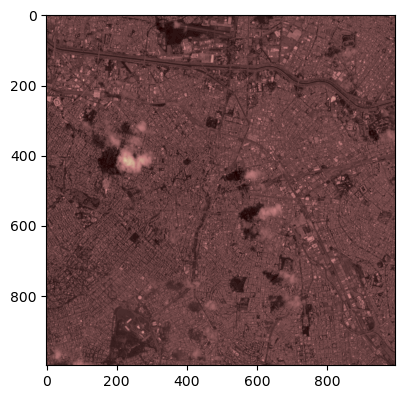

In [32]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(band1, cmap='pink')

# Utilizando Gdal para abrir e fazer alguns processos

In [22]:
#Abrindo com gdal
img_gdal = gdal.Open('D:\\codigos\\imagens\\imagem_teste_NDVI.tif')
#Dimensões
img_gdal.RasterXSize, img_gdal.RasterYSize


(995, 998)

In [23]:
#Contando o número de bandas pelo gdal
img_gdal.RasterCount

4

In [24]:
#Sistemas de coordenadas
img_gdal.GetProjection()

'PROJCS["WGS 84 / UTM zone 23S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-45],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32723"]]'

In [25]:
#Transformação geoespacial
geotransform = img_gdal.GetGeoTransform()
#Origem (x,y)
geotransform[0],geotransform[3]

(328320.0, 7399580.0)

In [26]:
#Tamanho do pixel
geotransform[1], 'x', geotransform[5]

(10.0, 'x', -10.0)

### Convertendo tif para png


In [27]:
driver = gdal.GetDriverByName('PNG')
output_path = "..\\..\\imagens\\imagem_convertida.png"
    
# Criando a cópia do raster no novo formato
output_dataset = driver.CreateCopy(output_path, img_gdal, 0)
output_dataset.FlushCache()  # Força a escrita no arquivo

In [28]:
# Verificando as coordenadas geográficas do raster
if img_gdal:
    gt = img_gdal.GetGeoTransform()
    
    x_min = gt[0]
    y_max = gt[3]
    x_max = x_min + (gt[1] * img_gdal.RasterXSize)
    y_min = y_max + (gt[5] * img_gdal.RasterYSize)

    print("\nExtensão do Raster:")
    print(f"x_min: {x_min}, x_max: {x_max}")
    print(f"y_min: {y_min}, y_max: {y_max}")



Extensão do Raster:
x_min: 328320.0, x_max: 338270.0
y_min: 7389600.0, y_max: 7399580.0


## Cortando uma imagem raster
### Porém como a imagem origem está em UTM, e informamos em longitude e latitude, precisamos converter com Transformer

In [ ]:

# Criando um transformador para converter de WGS84 (latitude/longitude) para o sistema do raster
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32723", always_xy=True) 

# Coordenadas originais (longitude, latitude)
lon_min, lat_min = -46.64, -23.56
lon_max, lat_max = -46.62, -23.54

# Convertendo para UTM
x_min_recorte, y_min_recorte = transformer.transform(lon_min, lat_min)
x_max_recorte, y_max_recorte = transformer.transform(lon_max, lat_max)

print(f"\nCoordenadas convertidas para UTM:")
print(f"x_min: {x_min_recorte}, x_max: {x_max_recorte}")
print(f"y_min: {y_min_recorte}, y_max: {y_max_recorte}")



Coordenadas convertidas para UTM:
x_min: 332615.95081250847, x_max: 334632.56791618344
y_min: 7393528.4927272275, y_max: 7395766.471244169


In [ ]:
#Recortando imagem com warp
if img_gdal:
    output_path_crop = "..\\..\\imagens\\imagem_cortada.tif"

    output_crop = gdal.Warp(output_path_crop, img_gdal, 
                            outputBounds=(x_min_recorte, y_min_recorte, x_max_recorte, y_max_recorte), 
                            format="GTiff")

    if output_crop is None:
        print("Erro ao recortar o raster.")
    else:
        output_crop.FlushCache()
        print(f"Raster recortado salvo em: {output_path_crop}")
img_gdal = None
output_crop = None

Raster recortado salvo em: ..\..\imagens\imagem_cortada.tif


In [31]:
imagem_cortada = rasterio.open('..\\..\\imagens\\imagem_cortada.tif')
imagem_cortada.meta, img.meta

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': 0.0,
  'width': 202,
  'height': 224,
  'count': 4,
  'crs': CRS.from_epsg(32723),
  'transform': Affine(9.983252988489966, 0.0, 332615.95081250847,
         0.0, -9.99097552206201, 7395766.471244169)},
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': 0.0,
  'width': 995,
  'height': 998,
  'count': 4,
  'crs': CRS.from_epsg(32723),
  'transform': Affine(10.0, 0.0, 328320.0,
         0.0, -10.0, 7399580.0)})

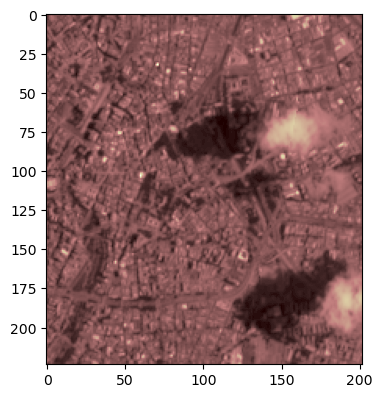

In [34]:
band1_imagem_cortada = imagem_cortada.read(1)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(band1_imagem_cortada, cmap='pink')